# Cardiovascular Disease Prediction Project
Student Name: Omar Degui
Student ID: 504792



In [1]:
import pandas as pd
import numpy as np
import itertools

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, roc_auc_score,confusion_matrix
import seaborn as sns
from sklearn.model_selection import learning_curve, validation_curve, train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate, RepeatedStratifiedKFold
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

from scipy.stats import loguniform,uniform

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline as IMBPipeline

import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

## Dataset description 
Our raw data collection describes the patients' health condition and wheter or not they are affected by a cardiovascular disease. 
It consists of 70000 records of patients data, 11 features + target. We can distinguish these features in objective (factual information), examination (results of medical examination) and subjective (information given by the patient).                                                         
In particular:
| Feature                                       | Type of feature     | Name        | Type of data  |
| --------------------------------------------- | ------------------- | ----------- | ------------- |
| Age                                           | Obj_Feature   | age          | int (days)    |
| Height                                        | Obj_Feature   | height       | int (cm)      |
| Weight                                        | Obj_Feature   | weight       | float (kg)    |
| Gender                                        | Obj_Feature   | gender       | binary        |
| Systolic  blood pressure                      | Exam_Feature | ap_hi        | int           |
| Diastolic blood pressure                      | Exam_Feature | ap_lo        | int           |
| Cholesterol                                   | Exam_Feature |  cholesterol  | categorical   |
| Glucose                                       | Exam_Feature | gluc         | categorical   |
| Smoking                                       | Subj_Feature  | smoke        | binary        |
| Alcohol Intake                                | Subj_Feature  | alco         | binary        |
| Physical Activity                             | Subj_Feature  | active      | binary        |
| Presence/absence of cardiovascular disease    | Target Variable     | cardio      | binary        |

#
The values of the gender feature are:
- 1 : woman
- 2 : man
The categorical values are : 
- 1: normal
- 2: above normal
- 3: well above normal
The values of the smoking feature are:
- 0 : no
- 1 : yes
The values of the alcohol intake feature are:
- 0 : no
- 1 : yes
The values of the physical activity  feature are:
- 0 : no
- 1 : yes
The values of the target variable are:
- 0 : absence of cardiovascular disease
- 1 : presence of cardiovascular disease


In [2]:
df = pd.read_csv('cardio_dataset.csv')
df

,id,age,gender,height,smoke,weight,ap_hi,ap_lo,cholesterol,gluc,smoke.1,alco,active,cardio
0,0,18393,2,168.0,0,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156.0,0,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165.0,0,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169.0,0,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156.0,0,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168.0,1,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158.0,0,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183.0,0,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,NaN,0,72.0,135,80,1,2,0,0,0,1


# Data preprocessing
Since the "age" feature is expressed in days, to make it more readable, we perform an integer division to get the age in years. In addiction, since it is not relevant for the design of this ML-oriented project, we can drop the feature "id".

In [3]:
df['age'] = df['age']//365
df.drop(columns=['id'], inplace=True)
df

,age,gender,height,smoke,weight,ap_hi,ap_lo,cholesterol,gluc,smoke.1,alco,active,cardio
0,50,2,168.0,0,62.0,110,80,1,1,0,0,1,0
1,55,1,156.0,0,85.0,140,90,3,1,0,0,1,1
2,51,1,165.0,0,64.0,130,70,3,1,0,0,0,1
3,48,2,169.0,0,82.0,150,100,1,1,0,0,1,1
4,47,1,156.0,0,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,52,2,168.0,1,76.0,120,80,1,1,1,0,1,0
69996,61,1,158.0,0,126.0,140,90,2,2,0,0,1,1
69997,52,2,183.0,0,105.0,180,90,3,1,0,1,0,1
69998,61,1,NaN,0,72.0,135,80,1,2,0,0,0,1


Let's visualize a description of the dataset

In [4]:
df.describe()

,age,gender,height,smoke,weight,ap_hi,ap_lo,cholesterol,gluc,smoke.1,alco,active,cardio
count,70000.000000,70000.000000,58100.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,52.840671,1.349571,164.361790,0.088129,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,6.766774,0.476838,8.177356,0.283484,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,29.000000,1.000000,55.000000,0.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,1.000000,159.000000,0.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,53.000000,1.000000,165.000000,0.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,58.000000,2.000000,170.000000,0.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,64.000000,2.000000,207.000000,1.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


Before to divide the dataset in target column and feature matrix, we can make some consideration about the dataset.
We know that:
- the systolic blood pressure is higher than the diastolic blood pressure (ap_hi > ap_lo)
- these values are greater than 0
So we can drop all the samples that do not satisfy these two conditions.

In [5]:
df.drop(df[(df['ap_lo'] > df['ap_hi']) | (df['ap_hi'] < 0) | (df['ap_lo'] < 0)].index,inplace=True)

In [6]:
df.describe()

,age,gender,height,smoke,weight,ap_hi,ap_lo,cholesterol,gluc,smoke.1,alco,active,cardio
count,68765.000000,68765.000000,57062.000000,68765.000000,68765.000000,68765.000000,68765.000000,68765.000000,68765.000000,68765.000000,68765.000000,68765.000000,68765.000000
mean,52.827514,1.348622,164.362535,0.087879,74.114964,128.841256,81.247975,1.364662,1.225580,0.087879,0.053341,0.803447,0.494758
std,6.769609,0.476538,8.157337,0.283121,14.332267,155.201984,9.677029,0.678879,0.571445,0.283121,0.224714,0.397395,0.499976
min,29.000000,1.000000,55.000000,0.000000,11.000000,12.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,1.000000,159.000000,0.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,53.000000,1.000000,165.000000,0.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,58.000000,2.000000,170.000000,0.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,64.000000,2.000000,207.000000,1.000000,200.000000,16020.000000,182.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


A person in a condition of hypertensive crisis has a systolic pressure of 180 mmHg or higher and a diastolic one of 110 mmHg or higher. 
A person in a condition of hypotension has a systolic pressure of 90 mmHg or lower and a diastolic one of 60 mmHg or lower.
Let's check how many patients respond positively to one of these condition in the following charts.

In [7]:
check = df[((df['ap_hi'] > 180) | (df['ap_hi'] < 90)) | ((df['ap_lo'] > 110) | (df['ap_lo'] < 60))][['ap_hi','ap_lo']]

In [8]:
check.describe()

,ap_hi,ap_lo
count,711.000000,711.000000
mean,367.850914,87.777778
std,1500.344574,36.095470
min,12.000000,0.000000
25%,125.000000,60.000000
50%,180.000000,100.000000
75%,200.000000,120.000000
max,16020.000000,182.000000


In [9]:
DeepnoteChart(check, """{"layer":[{"layer":[{"mark":{"clip":true,"type":"bar","color":"#4c78a8","tooltip":true},"encoding":{"x":{"sort":null,"type":"quantitative","field":"ap_hi","scale":{"type":"log"},"format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"},"y":{"sort":null,"type":"quantitative","scale":{"type":"linear"},"format":{"type":"default","decimals":null},"aggregate":"count","formatType":"numberFormatFromNumberType"}}}]}],"title":"","config":{"legend":{}},"$schema":"https://vega.github.io/schema/vega-lite/v5.json","encoding":{}}""")

In [10]:
DeepnoteChart(check, """{"layer":[{"layer":[{"mark":{"clip":true,"type":"bar","color":"#f58518","tooltip":true},"encoding":{"x":{"sort":null,"type":"quantitative","field":"ap_lo","scale":{"type":"linear"},"format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"},"y":{"sort":null,"type":"quantitative","scale":{"type":"linear"},"format":{"type":"default","decimals":null},"aggregate":"count","formatType":"numberFormatFromNumberType"}}}]}],"title":"","config":{"legend":{}},"$schema":"https://vega.github.io/schema/vega-lite/v5.json","encoding":{}}""")

From the charts is visible that some of the value of ap_hi and ap_lo are off.
- There are values of ap_hi higher than 240 and lower than 70.
- There are values of ap_lo higher than 140 and lower than 50.
We can then delete the samples that satisfy these condition because these values for ap_hi and ap_lo are really off (for example, we have some samples with ap_hi = 906  and ap_lo = 0).
These value are outliers, values that are significantly different from the rest of the dataset.

In [11]:
df.drop(df[((df['ap_hi'] >= 240) | (df['ap_hi'] <= 70)) | ((df['ap_lo'] >= 140) | (df['ap_lo'] <= 50))].index,inplace=True)

In [12]:
df.describe()

,age,gender,height,smoke,weight,ap_hi,ap_lo,cholesterol,gluc,smoke.1,alco,active,cardio
count,68054.000000,68054.000000,56492.000000,68054.000000,68054.000000,68054.000000,68054.000000,68054.000000,68054.000000,68054.000000,68054.000000,68054.000000,68054.000000
mean,52.822156,1.348459,164.375080,0.087636,74.074293,126.344183,81.179754,1.362447,1.224719,0.087636,0.053002,0.803582,0.492932
std,6.770884,0.476486,8.137723,0.282767,14.262211,15.846491,8.976642,0.677490,0.570798,0.282767,0.224039,0.397291,0.499954
min,29.000000,1.000000,55.000000,0.000000,11.000000,90.000000,60.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,1.000000,159.000000,0.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,53.000000,1.000000,165.000000,0.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,58.000000,2.000000,170.000000,0.000000,82.000000,140.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,64.000000,2.000000,207.000000,1.000000,200.000000,180.000000,110.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


Finally we can check if there are duplicate samples, and discarde them.

In [13]:
df.drop_duplicates(inplace=True)
df

,age,gender,height,smoke,weight,ap_hi,ap_lo,cholesterol,gluc,smoke.1,alco,active,cardio
0,50,2,168.0,0,62.0,110,80,1,1,0,0,1,0
1,55,1,156.0,0,85.0,140,90,3,1,0,0,1,1
2,51,1,165.0,0,64.0,130,70,3,1,0,0,0,1
3,48,2,169.0,0,82.0,150,100,1,1,0,0,1,1
4,47,1,156.0,0,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,57,1,165.0,0,80.0,150,80,1,1,0,0,1,1
69996,61,1,158.0,0,126.0,140,90,2,2,0,0,1,1
69997,52,2,183.0,0,105.0,180,90,3,1,0,1,0,1
69998,61,1,NaN,0,72.0,135,80,1,2,0,0,0,1


We can now separate the target column ("cardio") and the feature matrix.

In [14]:
y = df['cardio']
X = df.drop('cardio', axis = 1)

## Definition of the Data transformation pipeline
Let's first check if there are missing values to deal with and decide which features should we scale which not.

In [15]:
X.isnull().sum(axis=0)/X.shape[0]

age            0.000000
gender         0.000000
height         0.161905
smoke          0.000000
weight         0.000000
ap_hi          0.000000
ap_lo          0.000000
cholesterol    0.000000
gluc           0.000000
smoke.1        0.000000
alco           0.000000
active         0.000000
dtype: float64

For the feature <code>height</code> we are going to define the following pipeline:
1. a simple imputer to fill the missing values.
2. a standard scaler.
For all the other features we can just define a Standard Scaler, so that we can mantain the interpretability (the transformed features are still on the same scale as the original data). However, the Standard Scaler is sensitive to the presence of outliers because it uses the mean and standard deviation for scaling, so we should handling them (and we did in data cleaning part).
We can exclude the categorical and binary features from the scaling:
- Gender: binary
- Cholesterol: categorical
- Glucose : categorical
- Smoking: binary 
- Alcohol intake : binary 
- Physical activity: binary 

In [16]:
pipeline_height = Pipeline([
    ('imp',SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
transformation = ColumnTransformer(transformers = [
    ('height', pipeline_height ,['height'] ),
    ('std', StandardScaler(), ['age','weight','ap_hi','ap_lo'])
],
remainder='passthrough',
verbose_feature_names_out=False
)

## Training and test sets
We can split the entire dataset into training and test sets.
The training set will include the **80%** of the dataset while the test set will include the **20%** of the dataset.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=30, shuffle=True)

## Model selection
Up to now we have:
- dropped and modified some of the features of the original dataset, 
- divided it in matrix features and target column,
- defined the data transformation pipeline, 
- split the dataset in training and test sets.
We can now focus on the definition and selection of the best model, which will include:
- the column transformation;
- the best method to handle the imbalanced classes;
- the best algorithm for the dimentionality reduction;
- the best classifier.
This one will be the base model:

In [18]:
model_pipeline = IMBPipeline([
    ('trans', transformation),
    ('sampler',None),
    ('dim_reduction', None),
    ('classifier', RandomForestClassifier())
])

To check that everything is working correctly we can run the methods _fit_ and _predict_

In [19]:
model_pipeline.fit(X_train,y_train)

Pipeline(steps=[('trans',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('height',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['height']),
                                                 ('std', StandardScaler(),
                                                  ['age', 'weight', 'ap_hi',
                                                   'ap_lo'])],
                                   verbose_feature_names_out=False)),
                ('sampler', None), ('dim_reduction', None),
                ('classifier', RandomForestClassifier())])

In [20]:
model_pipeline.predict(X_test)

array([1, 0, 1, ..., 1, 0, 1])

Now we can define the configurations of the hyperparameters in order to use them in hyperparameter optimization phase of the model selection.
We have to check for every possible combination, which means combine a classifier with a dimensionality reduction technique and a method to handle imbalanced classes. Each of these 3 elements has a set of hyperparameters.
To get these combination we have to perform a cartesian product between all the elements we define for each component of the model.

In [21]:
sampler_configs = [
    {
        'sampler':[None],
    },
    {
        'sampler':[SMOTE(n_jobs=-1)],
        'sampler__sampling_strategy':['minority', 1.2, 0.9, 0.7]
    },
    {
        'sampler':[RandomOverSampler()],
        'sampler__sampling_strategy':['minority', 1.2, 0.9, 0.7]
    }
]

dim_reduction_configs = [
    {
        'dim_reduction': [None]
    },
    {
        'dim_reduction': [PCA()],
        'dim_reduction__n_components': [0.5, 0.7, 0.9]
    },
    {
        'dim_reduction': [LDA()]
    },
    {
        'dim_reduction': [SFS(estimator=Perceptron(), cv = None, scoring = 'f1')],
        'dim_reduction__estimator': [Perceptron(), LogisticRegression()],
        'dim_reduction__k_features' : [5,7,10]  
    }
]

classifier_configs = [
    {
        'classifier__eta0' : loguniform(0.001,100),
        'classifier': [Perceptron()] ,
        'classifier__max_iter': [1,5,10,15,50,100] ,
        'classifier__class_weight' : [None, 'balanced']

    },
    {
        'classifier': [LogisticRegression(solver='saga')],
        'classifier__C' : loguniform(0.001,100),
        'classifier__penalty': ['l1','l2'],
        'classifier__class_weight' : [None, 'balanced']

    },
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [3,5,7,9]
    },
    {
        'classifier' : [RandomForestClassifier()],
        'classifier__n_estimators' : [10,50,100, 500]
    }
]

To make all the configuration possible we will use list comprehension and the <code> ** </code> operator, which allow us to combine dictionaries. In particular we can extract the pair key-value of each dictionary in the list of each component of the model. For example:
- from sample_configs we get the element in the index [0], from which we get the pairs key-value, in this case <code>'sampler':[None]</code>.
- from dim_reduction_configs we get the element in the index [0], from which we get the pairs key-value, in this case <code>'dim_reduction': [None]</code>.
- from classifier_configs we get the element in the index [0], from which we get the pairs key-value, in this case <code>
    'classifier__eta0': loguniform(0.001,100),
    'classifier': [Perceptron()],
    'classifier__max_iter': [1, 5, 10, 15, 50, 100],
    'classifier__class_weight': [None, 'balanced']</code>.

So finally we get:<code> 
{'sampler': [None],
    'dim_reduction': [None],
    'classifier__eta0': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7fc105378a30>,
    'classifier': [Perceptron()],
    'classifier__max_iter': [1, 5, 10, 15],
    'classifier__class_weight': [None, 'balanced']}
</code>
Which will be one element of the list of combinations

In [22]:
all_configs =  [{**sampler, **dim_reduction, **classifier} for sampler in sampler_configs for dim_reduction in dim_reduction_configs for classifier in classifier_configs]

In [23]:
all_configs[:5]

[{'sampler': [None],
  'dim_reduction': [PCA()],
  'dim_reduction__n_components': [0.5, 0.7, 0.9],
  'classifier__eta0': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7fa9184a7fd0>,
  'classifier': [Perceptron()],
  'classifier__max_iter': [1, 5, 10, 15, 50, 100],
  'classifier__class_weight': [None, 'balanced']},
 {'sampler': [None],
  'dim_reduction': [PCA()],
  'dim_reduction__n_components': [0.5, 0.7, 0.9],
  'classifier': [LogisticRegression(solver='saga')],
  'classifier__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7fa9184b8250>,
  'classifier__penalty': ['l1', 'l2'],
  'classifier__class_weight': [None, 'balanced']},
 {'sampler': [None],
  'dim_reduction': [PCA()],
  'dim_reduction__n_components': [0.5, 0.7, 0.9],
  'classifier': [KNeighborsClassifier()],
  'classifier__n_neighbors': [3, 5, 7, 9]},
 {'sampler': [None],
  'dim_reduction': [PCA()],
  'dim_reduction__n_components': [0.5, 0.7, 0.9],
  'classifier': [RandomForestClassifier()],
  'c

We can now use the nested-cross validation to identify the best 5 models.
To do so we will define:
- the inner loop, using a random/halving Grid search to perform a hyperparameter optimization
- the outer loop, perfom cross-validation using the hyperparameters founded found in the inner loop

In [24]:
rs = RandomizedSearchCV(model_pipeline,
    param_distributions=all_configs,
    n_iter=len(all_configs) * 5,
    n_jobs=-1,
    cv = 2,
    scoring='f1'
)

In [25]:
scores = cross_validate(rs, X_train, y_train, scoring='f1', cv = 5, return_estimator=True, verbose=3) 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/root/venv/lib/python3.9/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/root/venv/lib/python3.9/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/root/venv/lib/python3.9/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/root/venv/lib/python3.9/site-packages/imblearn/over_sampling/_smote/base.py:336: Future

We can now visualize which are the 5 best models and get also which parameters they have.

In [26]:
for index, estimator in enumerate(scores['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores['test_score'][index])
    print('-'*10)

None
PCA(n_components=0.5)
Perceptron(eta0=0.0019698174728303027, max_iter=100) {'alpha': 0.0001, 'class_weight': None, 'early_stopping': False, 'eta0': 0.0019698174728303027, 'fit_intercept': True, 'l1_ratio': 0.15, 'max_iter': 100, 'n_iter_no_change': 5, 'n_jobs': None, 'penalty': None, 'random_state': 0, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
0.5676724677601102
----------
SMOTE(n_jobs=-1, sampling_strategy='minority')
PCA(n_components=0.9)
LogisticRegression(C=0.010268029971720813, class_weight='balanced',
                   solver='saga') {'C': 0.010268029971720813, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
0.7084589109905566
----------
None
PCA(n_components=0.9)
LogisticRegression(C=0.02317572836074799

Now we can visualize which models performs better on the entire training dataset and evaluate their performance on the test set.

In [27]:
for estimator in scores['estimator']:
    pred_train = estimator.best_estimator_.fit(X_train, y_train)
    pred_train = estimator.best_estimator_.predict(X_train)
    pred_test = estimator.best_estimator_.predict(X_test)
    f1_train = f1_score(y_train, pred_train)
    f1_test = f1_score(y_test, pred_test)
    difference = abs(f1_train-f1_test)
    print(f'F1 on training set:{f1_train}, F1 on test set:{f1_test}, difference:{difference}')

F1 on training set:0.6851197861983392, F1 on test set:0.6860325434094136, difference:0.000912757211074311
F1 on training set:0.7098061343758817, F1 on test set:0.6987288478665695, difference:0.011077286509312168
F1 on training set:0.7116485804669043, F1 on test set:0.7013654618473896, difference:0.010283118619514697
F1 on training set:0.7107289777933751, F1 on test set:0.7035443236053517, difference:0.007184654188023387
F1 on training set:0.7117598766544523, F1 on test set:0.7010690458966321, difference:0.01069083075782018


## Final predictive model
Now we can select the model that performed better and re-run the hyperparameter optimization to see if we can improve its performance.
First we define the pipeline:

In [28]:
best_model_pipeline = IMBPipeline([
    ('trans',transformation),
    ('dim_reduction', PCA()),
    ('classifier', Perceptron(class_weight='balanced'))
])

In [29]:
dim_reduction_configs = [
    {
        'dim_reduction__n_components' : np.arange(0, 0.9, 0.05)
    }
]

classifier_configs = [
    {
        'classifier__eta0' : uniform(loc = 0.001, scale = 50),
        'classifier__max_iter': [i for i in range(7,100)]
    }
]
params =  [{**dim_reduction, **classifier}for dim_reduction in dim_reduction_configs for classifier in classifier_configs]

After defining the parameters according to the first hyperparameter optimization results, we can define a RandomSearchCV to identify a new configuration, and use it to fit the train dataset and compute f1-score to evaluate it.

In [30]:
rs_best = RandomizedSearchCV(
    estimator = best_model_pipeline,
    param_distributions = params,
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3),
    n_iter=30,
    scoring='f1'
)

In [31]:
rs_best.fit(X_train, y_train) 

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=None),
                   estimator=Pipeline(steps=[('trans',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('height',
                                                                               Pipeline(steps=[('imp',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['height']),
                                                                              ('std',
                                                                               StandardScaler(),
                                                                               ['age',
                                                                                'weight',
                                                                                'ap_hi',
                                                                                'ap_lo'])],
                                                                verbose_feature_name...
                   param_distributions=[{'classifier__eta0': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fa948630bb0>,
                                         'classifier__max_iter': [7, 8, 9, 10,
                                                                  11, 12, 13,
                                                                  14, 15, 16,
                                                                  17, 18, 19,
                                                                  20, 21, 22,
                                                                  23, 24, 25,
                                                                  26, 27, 28,
                                                                  29, 30, 31,
                                                                  32, 33, 34,
                                                                  35, 36, ...],
                                         'dim_reduction__n_components': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85])}],
                   scoring='f1')

In [32]:
rs_best.best_estimator_

Pipeline(steps=[('trans',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('height',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['height']),
                                                 ('std', StandardScaler(),
                                                  ['age', 'weight', 'ap_hi',
                                                   'ap_lo'])],
                                   verbose_feature_names_out=False)),
                ('dim_reduction', PCA(n_components=0.35000000000000003)),
                ('classifier',
                 Perceptron(class_weight='balanced', eta0=42.064550423193616,
                            max_iter=8))])

In [33]:
f1_score(y_test, rs_best.best_estimator_.predict(X_test))

0.7191757608621976

## Learning and validation curve
We can now visualize:
- the learning curve to see how the size of the training and test sets influence the performance of the final model
- validation curve to see how the hyperparameters influence the performance of the final model.

In [34]:
final_classifier = rs_best.best_estimator_

In [43]:
train_sizes, train_scores, test_scores = learning_curve(final_classifier,
                                                       X=X_train,
                                                       y=y_train,
                                                       train_sizes= 
                                                       [0.01,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                       cv = 2,
                                                       n_jobs = -1,
                                                       scoring = 'f1',
                                                       shuffle = False)

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/shared-libs/pyt

(0.0, 1.0)

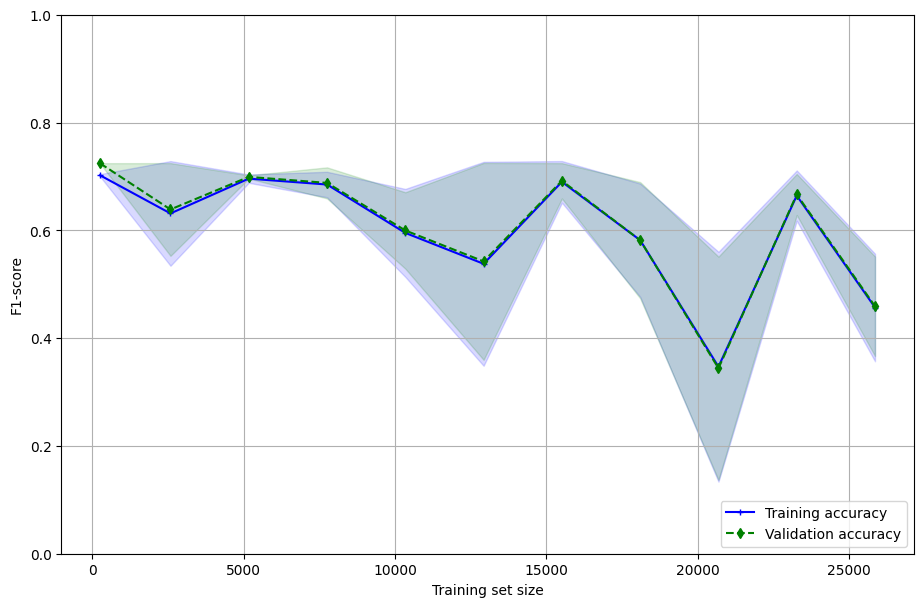

In [44]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(11,7))
ax = fig.add_subplot()

ax.plot(train_sizes, train_mean,
         color='blue', marker='+',
         markersize=5, label='Training accuracy')

ax.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='d', markersize=5,
         label='Validation accuracy')

ax.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Training set size')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
ax.set_ylim([0.0, 1.0])

In [45]:
eta0 = [0.001,0.1,1,10,100]
train_scores, test_scores = validation_curve(final_classifier,
        X=X_train, 
        y=y_train, 
        param_range=eta0, 
        param_name='classifier__eta0',
        cv=5, 
        n_jobs=-1, 
        scoring='f1'
)

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/shared-libs/pyt

(0.0005623413251903491, 100)

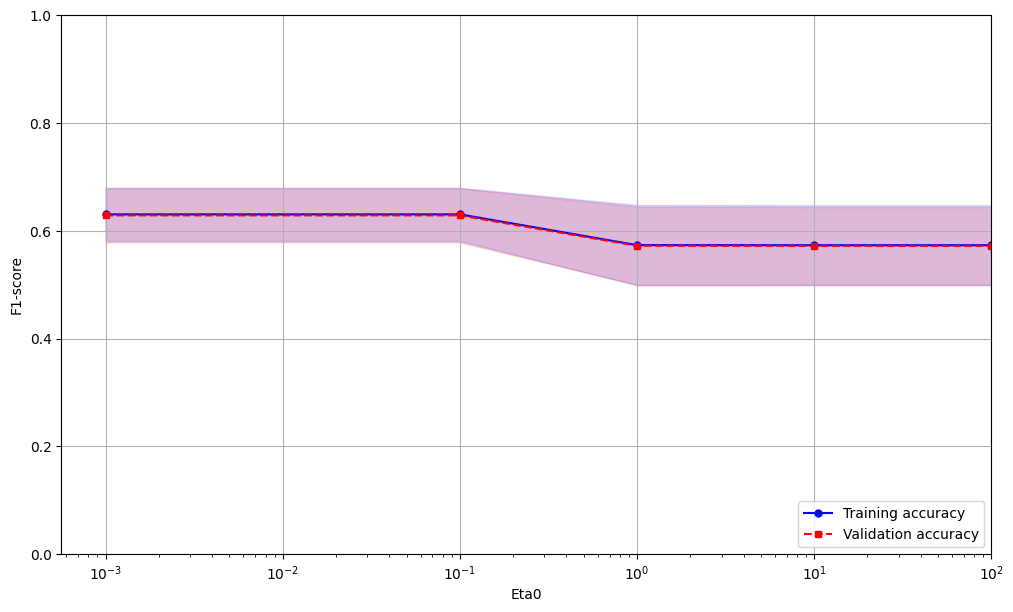

In [46]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()
ax.plot(eta0, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

ax.fill_between(eta0,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(eta0, test_mean,
         color='red', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

ax.fill_between(eta0,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='red')

ax.grid()
ax.set_xlabel('Eta0')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
ax.set_ylim([0.0, 1])
ax.set_xscale('log')
ax.set_xlim([0.0,100])

In [47]:
max_iter = [1,5,10,15,20,25,100]
train_scores, test_scores = validation_curve(final_classifier,
        X=X_train, 
        y=y_train, 
        param_range=max_iter, 
        param_name='classifier__max_iter',
        cv=5, 
        n_jobs=-1, 
        scoring='f1'
)

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/shared-libs/pyt

(1, 100)

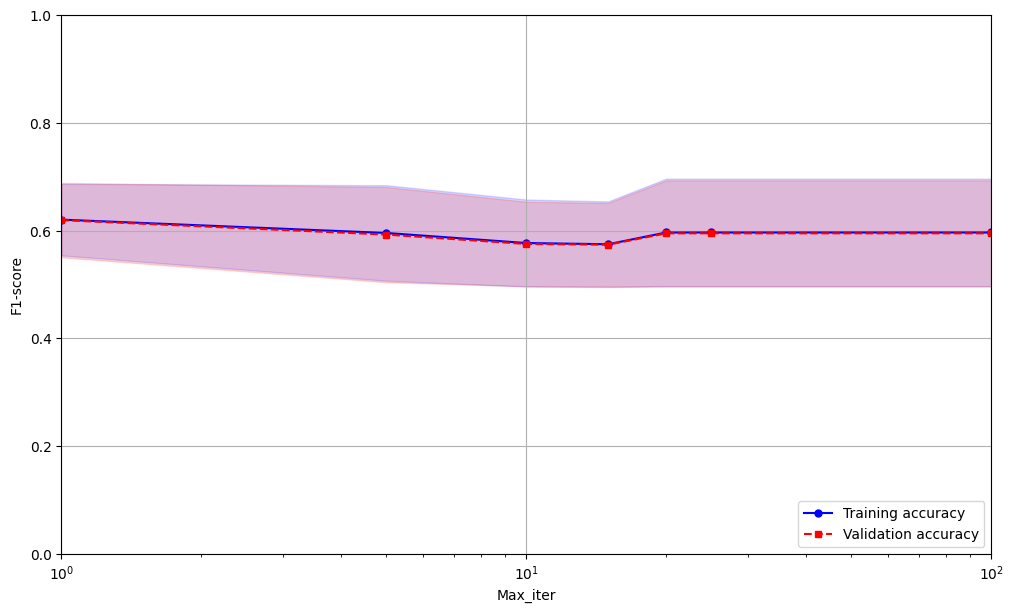

In [48]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()
ax.plot(max_iter, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

ax.fill_between(max_iter,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(max_iter, test_mean,
         color='red', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

ax.fill_between(max_iter,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='red')

ax.grid()
ax.set_xlabel('Max_iter')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
ax.set_ylim([0.0, 1])
ax.set_xscale('log')
ax.set_xlim([1,100])

From the curves we can conclude that:
- the <code>train size</code> influences a lot the performance of the model, and that with a train size of **0.9** the performance will increase a lot.
- if the <code>eta0</code> is smaller or equal to 0.1, the performance of the model will increase.
- the model's performance is at highest point when the <code>max_iter</code> parameter is smaller or equal to **1**.

In [49]:
best_model_pipeline = IMBPipeline([
    ('trans',transformation),
    ('dim_reduction',PCA(n_components=0.55)),
    ('classifier', Perceptron(class_weight='balanced', eta0=0.1,max_iter=1))
])

In [50]:
best_model_pipeline.fit(X_train, y_train) 

Pipeline(steps=[('trans',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('height',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['height']),
                                                 ('std', StandardScaler(),
                                                  ['age', 'weight', 'ap_hi',
                                                   'ap_lo'])],
                                   verbose_feature_names_out=False)),
                ('dim_reduction', PCA(n_components=0.55)),
                ('classifier',
                 Perceptron(class_weight='balanced', eta0=0.1, max_iter=1))])

In [51]:
f1_score(y_test, best_model_pipeline.predict(X_test))

0.7099358974358975

We can also plot the confusion matrix to make better evaluation about the model

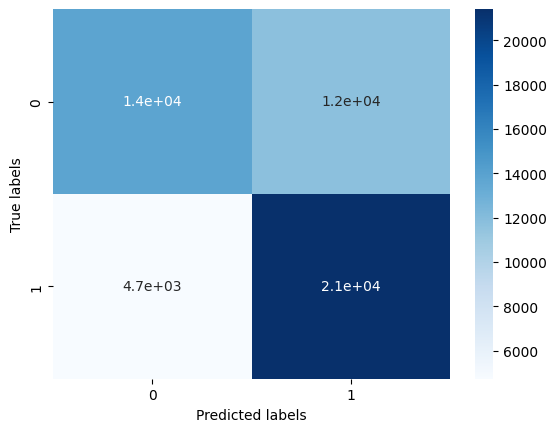

In [52]:
cm = confusion_matrix(y_train, final_classifier.predict(X_train))

sns.heatmap(cm, annot=True, cmap='Blues')

plt.xlabel('Predicted labels')
plt.ylabel('True labels')

plt.show()

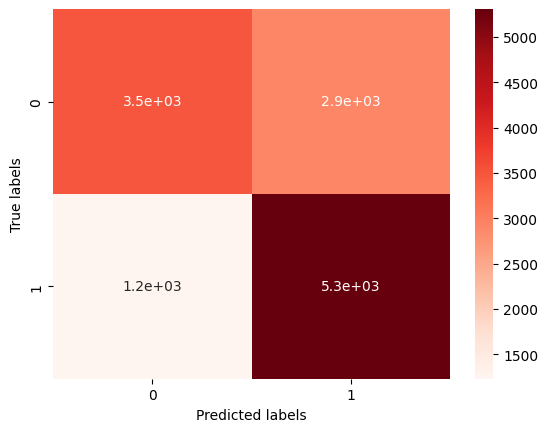

In [53]:
cm = confusion_matrix(y_test, final_classifier.predict(X_test))

sns.heatmap(cm, annot=True, cmap='Reds')

plt.xlabel('Predicted labels')
plt.ylabel('True labels')

plt.show()

We can enlight the fact that in both the confusion matrixes (one for the training set and another one for the test set):
- most of the instances are predicted correctly; 
- we have a more false positives than false negatives.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9adbd0d3-010f-4a01-b9bd-ce300c4c301f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>